In [2]:
from helpers import *
import matplotlib.pyplot as plt
from itertools import groupby
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%load_ext autoreload
%autoreload 2

C:\Users\Claudia\AppData\Roaming\Python\Python39\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Claudia\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\Claudia\AppData\Roaming\Python\Python39\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>Load data</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        In helpers there is a function already preprocessing the data so that it can be used directly.
    </span>
</div>

In [3]:
# get the data
articles, categories, links, paths_finished, paths_unfinished, paths_all, shortest_path_distance = load_data()

</div>
<div class="4. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>1. Between game feature extraction</h2>
        <h4>Here we will extract features based on the history of games for a player. The aim is to find features that can potentially seperate the classes <code class='python'>finished</code> and <code class='python'>unfinished (i.e. timeouit or restart)</code></h4>
    </span>
</div>
</div>

</div>
<div class="1.1 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.1 Number of unfinished games.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        For the first feature we consider the number of unfinished games in total (excluding the last game) of the player.
    </span>
</div>

In [4]:
#Create DataFrame with history of games player
players_record = pd.DataFrame(paths_all.sort_values('timestamp').groupby('hashedIpAddress')['type'].apply(list))
players_record = players_record.rename(columns={'type': 'between_game'})

#Extract if last game was finished or unfinished (1 = finished, 0 = unfinished)
players_record['last_game'] = players_record['between_game'].apply(lambda l : 1 if l[-1] == 'finished' else 0)

#Extract number of unfinished games in history
players_record['history_unfinished_games'] = players_record['between_game'].apply(lambda x: x[:-1].count('timeout')+x[:-1].count('restart'))

#Display snipped of result
players_record.head(4)

,between_game,last_game,history_unfinished_games
hashedIpAddress,,,
000386124f307de8,"[finished, timeout]",0,0
0007183207b6008f,"[finished, finished, finished]",1,0
000a09e202e88d10,[finished],1,0
000a5bac5b7781ea,[finished],1,0


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Let's see if this feature significantly different between players ending on either <code class='python'>finished</code> or <code class='python'>unfinished</code>
    </span>
</div>

In [5]:
#calculate bootstrap finished
ci_finished, stats_finished = bootstrap_CI(players_record[players_record['last_game']==1]['history_unfinished_games'], 10000, 'arithmetic', True)

#calculate bootstrap unfinished
ci_unfinished, stats_unfinished = bootstrap_CI(players_record[players_record['last_game']==0]['history_unfinished_games'], 10000, 'arithmetic', True)

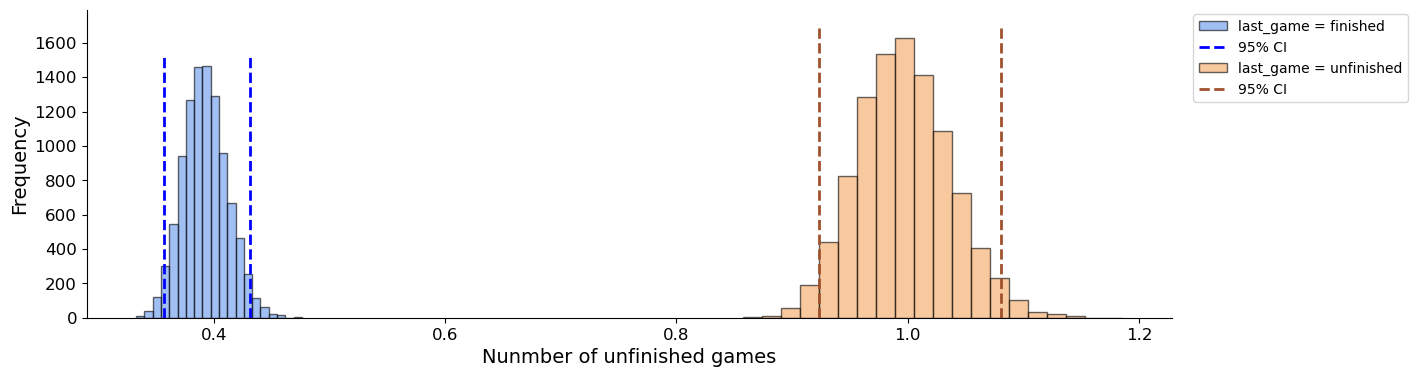

In [6]:
#Plot confidence intervals
fig, ax = plt.subplots(figsize=(14,4))

#finished
ax.hist(stats_finished, bins=20, edgecolor = 'k', color='cornflowerblue',alpha = 0.6, label = 'last_game = finished')
ax.vlines(ci_finished, 0, ax.get_ylim()[1], ls='--', color='blue', linewidth=2, label = '95% CI')

#unfinished
ax.hist(stats_unfinished, bins=20, edgecolor = 'k', color='sandybrown', alpha = 0.6, label = 'last_game = unfinished')
ax.vlines(ci_unfinished, 0, ax.get_ylim()[1], ls='--', color='sienna', linewidth=2, label = '95% CI')

ax.set_xlabel('Nunmber of unfinished games', fontsize=14)
ax.set_ylabel('Frequency',  fontsize=14)
ax.legend(loc=(1.02, 0.70));

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

#fig.savefig('figures/prop_finished_games.svg', bbox_inches='tight')


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we find this features is signficantly different between both groups.
    </span>
</div>

</div>
<div class="1.2 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.2 Number succesive unfinished games before last game.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        For the second feature we consider the number of chained unfinished games up to the last game. Hence for <code class='python'>[timeout restart timeout]</code> we have <code class='python'>succesive_unfinished = 2</code>. However for <code class='python'>[timeout restart finished timeout]</code> we have <code class='python'>succesive_unfinished = 0</code> 
    </span>
</div>

In [7]:
#Find length of most recent succisive unfinished streak
def chained_unfinished(x):
    
    #join games together with a empty space in between
    x_join = ' '.join(x)
    
    #Split games based on most recent finished games
    x_split = x_join.rsplit('finished', 1)
    
    #Extract length of chained unfinished games
    x_chained_length = len(x_split[-1].split())
    
    return x_chained_length
        

In [8]:
players_record['chained_unfinished'] = players_record['between_game'].apply(lambda x: chained_unfinished(x[:-1]))

In [9]:
players_record.head(4)

,between_game,last_game,history_unfinished_games,chained_unfinished
hashedIpAddress,,,,
000386124f307de8,"[finished, timeout]",0,0,0
0007183207b6008f,"[finished, finished, finished]",1,0,0
000a09e202e88d10,[finished],1,0,0
000a5bac5b7781ea,[finished],1,0,0


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Let's see if this feature significantly different between players ending on either <code class='python'>finished</code> or <code class='python'>unfinished</code>
    </span>
</div>

In [10]:
#calculate bootstrap finished
ci_finished, stats_finished = bootstrap_CI(players_record[players_record['last_game']==1]['chained_unfinished'], 10000, 'arithmetic', True)

#calculate bootstrap unfinished
ci_unfinished, stats_unfinished = bootstrap_CI(players_record[players_record['last_game']==0]['chained_unfinished'], 10000, 'arithmetic', True)

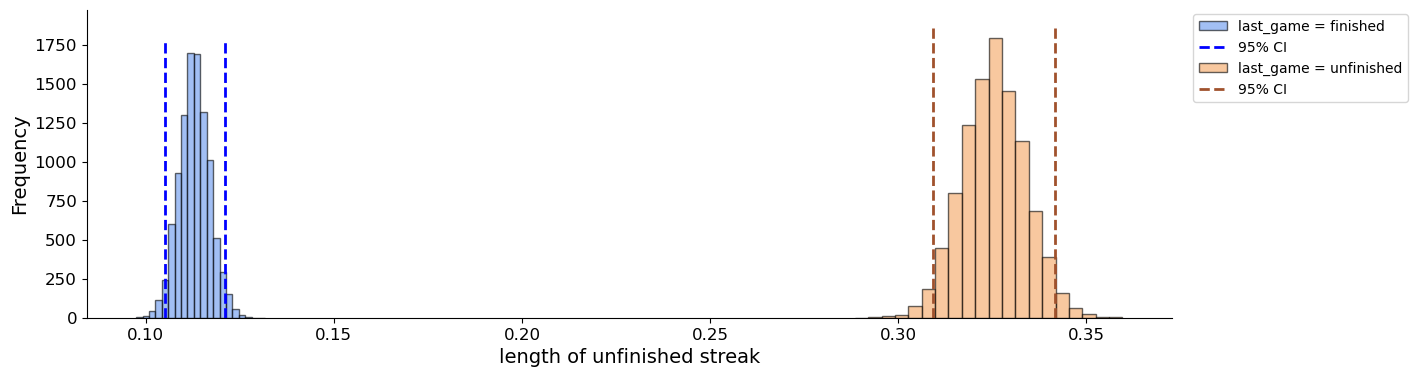

In [11]:
#Plot confidence intervals
fig, ax = plt.subplots(figsize=(14,4))

#finished
ax.hist(stats_finished, bins=20, edgecolor = 'k', color='cornflowerblue',alpha = 0.6, label = 'last_game = finished')
ax.vlines(ci_finished, 0, ax.get_ylim()[1], ls='--', color='blue', linewidth=2, label = '95% CI')

#unfinished
ax.hist(stats_unfinished, bins=20, edgecolor = 'k', color='sandybrown', alpha = 0.6, label = 'last_game = unfinished')
ax.vlines(ci_unfinished, 0, ax.get_ylim()[1], ls='--', color='sienna', linewidth=2, label = '95% CI')

ax.set_xlabel('length of unfinished streak', fontsize=14)
ax.set_ylabel('Frequency',  fontsize=14)
ax.legend(loc=(1.02, 0.70));

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

#fig.savefig('figures/prop_finished_games.svg', bbox_inches='tight')


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we find this features is signficantly different between both groups.
    </span>
</div>

</div>
<div class="1.2 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.3 Time difference between first and last game.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        For the third feature we focus on how long ago the first game of an individual players was with respect to their last.
    </span>
</div>

In [12]:
#Find minimum and maximum timestamp for every player
time_stamps = paths_all.groupby('hashedIpAddress')['timestamp'].agg(['max', 'min']).rename(columns={'max': 'max_timestamp', 'min': 'min_timestamp'})

#merge to players_record DataFrame
players_record = players_record.merge(time_stamps, on='hashedIpAddress')  

#Create first_last_time column
players_record['first_last_time'] = players_record['max_timestamp'] - players_record['min_timestamp']

<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Let's see if this feature significantly different between players ending on either <code class='python'>finished</code> or <code class='python'>unfinished</code>
    </span>
</div>

In [13]:
#calculate bootstrap finished
ci_finished, stats_finished = bootstrap_CI(players_record[players_record['last_game']==1]['first_last_time'], 10000, 'arithmetic', True)

#calculate bootstrap unfinished
ci_unfinished, stats_unfinished = bootstrap_CI(players_record[players_record['last_game']==0]['first_last_time'], 10000, 'arithmetic', True)

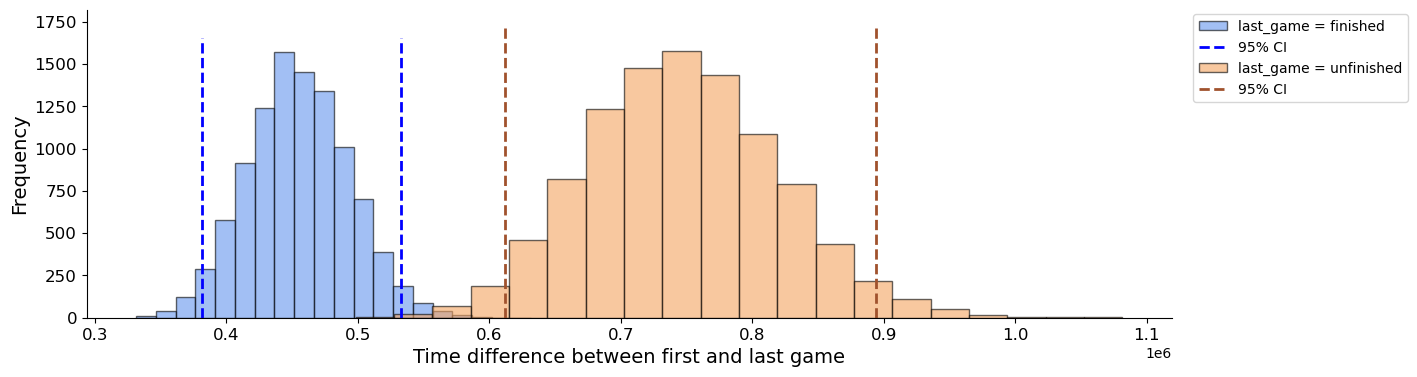

In [14]:
#Plot confidence intervals
fig, ax = plt.subplots(figsize=(14,4))

#finished
ax.hist(stats_finished, bins=20, edgecolor = 'k', color='cornflowerblue',alpha = 0.6, label = 'last_game = finished')
ax.vlines(ci_finished, 0, ax.get_ylim()[1], ls='--', color='blue', linewidth=2, label = '95% CI')

#unfinished
ax.hist(stats_unfinished, bins=20, edgecolor = 'k', color='sandybrown', alpha = 0.6, label = 'last_game = unfinished')
ax.vlines(ci_unfinished, 0, ax.get_ylim()[1], ls='--', color='sienna', linewidth=2, label = '95% CI')

ax.set_xlabel('Time difference between first and last game', fontsize=14)
ax.set_ylabel('Frequency',  fontsize=14)
ax.legend(loc=(1.02, 0.70));

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

#fig.savefig('figures/prop_finished_games.svg', bbox_inches='tight')


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we find this features is signficantly different between both groups.
    </span>
</div>

</div>
<div class="1.2 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>1.4 Longest win streak.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        For the fourth feature we examine the longest finished streak the player has had in the past.
    </span>
</div>

In [15]:
#function to find finished maximum finished streak
def finished_streak(x):
    
    streaks = {'finished': 0, 'restart': 0, 'timeout': 0}
    
    for k, v in groupby(x):  
        streak = len(list(v))
        if streaks[k] < streak:
            streaks[k] = streak
    
    return streaks['finished']

In [16]:
players_record['max_finished_streak'] = players_record['between_game'].apply(lambda x: finished_streak(x[:-1]))
players_record.head(4)

,between_game,last_game,history_unfinished_games,chained_unfinished,max_timestamp,min_timestamp,first_last_time,max_finished_streak
hashedIpAddress,,,,,,,,
000386124f307de8,"[finished, timeout]",0,0,0,1351279254,1351277431,1823,1
0007183207b6008f,"[finished, finished, finished]",1,0,0,1347370274,1347370093,181,2
000a09e202e88d10,[finished],1,0,0,1250316279,1250316279,0,0
000a5bac5b7781ea,[finished],1,0,0,1298781161,1298781161,0,0


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        There is 1 single player with a max_finished_streak of 4864 finshed games. We want to remove this outlier as it will heaviliy influence the bootstrap.
    </span>
</div>

In [17]:
players_record['max_finished_streak'].unique()

array([   1,    2,    0,    6,    8,    3,    4,    5,    9,    7,   14,
         44,   16,   11,  171,   15,   12,   18,   26,   19,   13,   33,
         25,   32,   20,   36,   35, 4864,   10,   22,  138,   34,   38,
         24,   30,   31,   17,   27,   82,   28,   29,   61,   23,   37,
         21,   74,  194,   59,   80,   46,   79,  108,  117,   39,  112,
         43,   68,   48,   70,  230,  169,   51,   60,   50,  148],
      dtype=int64)

In [18]:
players_record_no_outlier = players_record[players_record['max_finished_streak'] != players_record['max_finished_streak'].max()] 

In [19]:
#calculate bootstrap finished
ci_finished, stats_finished = bootstrap_CI(players_record_no_outlier[players_record_no_outlier['last_game']==1]['max_finished_streak'], 10000, 'arithmetic', True)

#calculate bootstrap unfinished
ci_unfinished, stats_unfinished = bootstrap_CI(players_record_no_outlier[players_record_no_outlier['last_game']==0]['max_finished_streak'], 10000, 'arithmetic', True)

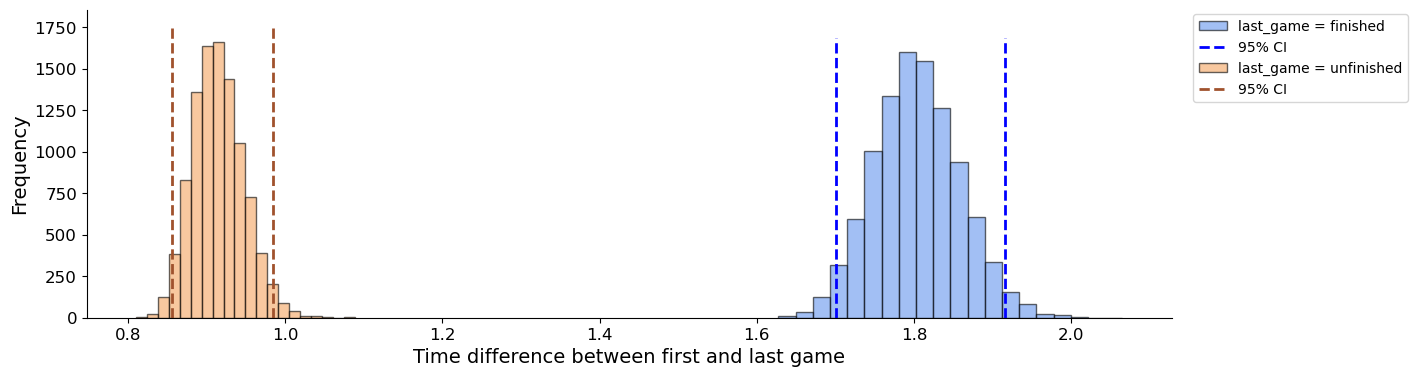

In [20]:
#Plot confidence intervals
fig, ax = plt.subplots(figsize=(14,4))

#finished
ax.hist(stats_finished, bins=20, edgecolor = 'k', color='cornflowerblue',alpha = 0.6, label = 'last_game = finished')
ax.vlines(ci_finished, 0, ax.get_ylim()[1], ls='--', color='blue', linewidth=2, label = '95% CI')

#unfinished
ax.hist(stats_unfinished, bins=20, edgecolor = 'k', color='sandybrown', alpha = 0.6, label = 'last_game = unfinished')
ax.vlines(ci_unfinished, 0, ax.get_ylim()[1], ls='--', color='sienna', linewidth=2, label = '95% CI')

ax.set_xlabel('Time difference between first and last game', fontsize=14)
ax.set_ylabel('Frequency',  fontsize=14)
ax.legend(loc=(1.02, 0.70));

#Remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=12)

#fig.savefig('figures/prop_finished_games.svg', bbox_inches='tight')


<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we find this features is signficantly different between both groups.
    </span>
</div>

</div>
<div class="4. Header" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white;">
       <h2>2. Feature analysis</h2>
        <h4>Here we will have a look at the features to see how they correlate with each other</h4>
    </span>
</div>
</div>

</div>
<div class="1.2 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.1 Standardization.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We will standardizer all features before performing further analysis
    </span>
</div>

In [21]:
#Extract features
features = ['history_unfinished_games', 'chained_unfinished', 'first_last_time', 'max_finished_streak']
X = players_record[features]

#Standardize data
X = (X-X.mean())/X.std()

#Display snippet of result
X.head(4)

,history_unfinished_games,chained_unfinished,first_last_time,max_finished_streak
hashedIpAddress,,,,
000386124f307de8,-0.232938,-0.336306,-0.110171,-0.019725
0007183207b6008f,-0.232938,-0.336306,-0.110488,0.008317
000a09e202e88d10,-0.232938,-0.336306,-0.110523,-0.047768
000a5bac5b7781ea,-0.232938,-0.336306,-0.110523,-0.047768


</div>
<div class="1.2 explanation" style='background-color:#08135c; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:white">
       <h3>2.2 Covariance matrix.</h3>
    </span>
</div>
</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        We will display the coveriance matrix of all the features in a heatmap
    </span>
</div>

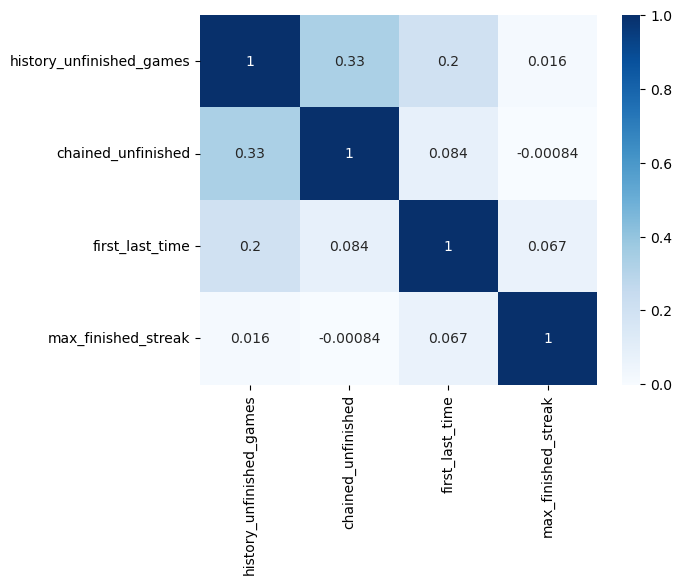

In [21]:
covariance_matrix = np.cov(X.to_numpy().T)

sns.heatmap(covariance_matrix, cmap='Blues', annot=True, xticklabels=features, yticklabels=features );
plt.xticks(rotation=90);

</div>
<div class="1.1 explanation" style='background-color:#faefe1; border-left: solid #darkblue 4px; border-radius: 4px; padding:0.7em;'>
    <span style="color:black">
        Hence we see that the cross-correlation is not high between the different features, indicating that they all independently contribute information to our model. After this it is interesting to look at the in-game features.
    </span>
</div>

In [22]:
#Store between_game features in csv file
X.to_csv("data/between_game_features.csv", index = True, encoding='utf-8')

#Store labels in csv file
Y = players_record[['last_game']]
Y.to_csv("data/labels.csv", index = True, encoding='utf-8')